# Variational Auto Encoders End-to-End
Deep generative models are neural network architectures & algorithms that learn the key characteristics of the input data, to generate similar data. There are various approaches to deep generative modelling, like VAEs (variational Auto Encoders), GANs (Generative Adversarial Networks) and Diffusion models. Each have their own approach of learning the underlying characteristics of the data to generate similar samples. Among the generative models, auto-encoders are specialized at learning the underlying distribution of the data. Auto encoders combine the learnings from variational inference and deep neural networks.

In general autoencoders consists of two neural network models - Encoder Model and a Decoder Model. The encoder model is a series of neural network layers that learn the distribution of the data (latent vector) by reducing the dimensionality of the input space to a compressed vector. The decoder model is another neural network model that uses the compressed vector to learn and regenerate the same sample. The network is penalized for not regnerating the image using mean squared error, and this helps the network fine tune the latent vector to learn the correct representation of input data.

However, there are a few fundamental problems associated with traditional encoders.

1. The learnt compressed vector in autoencoders does not follow any distribution rules. This is because each input is learnt independently, as a result the outcome (latent vector) of any two data points belonging to same class can have different lower/upper bounds. For example, a latent vector learnt for an image of dog can be from -15 to 20 in a 1D dimension, where as another image from the same class can have a lower and upper bounds of -1 to 1.5.
2. The latent space distribution is not continuous, the samples from same class could be very far from each other.

Thus, in traditional autoencoders lack of proper shape, distribution rules in the learnt vector makes it difficult to renegerate new samples of same class.

Variational autoencoders solve this problem by forcing the encoder to learn the latent space distribution as a standard normal distribution. This is in addition to the original learning objective, i.e. to learn the latent vector. The standard normal distribution makes the samples from same class close to each other and helps to easily draw new samples.

The below diagram shows the high level network architecture of VAE

![image.png](https://github.com/sriksmachi/sriksml/blob/main/genai/images/vae-hld.png?raw=1)

## Making a face smile more

In this notebook we will learn to build a variational auto encoder using the face images dataset, tensforflow. We will achieve the following things
1. Preparing data for training VAEs
2. VAE Encoder-Decoder architecture for Images
3. VAE loss function
4. Generating images from latent vector using input images
5. Generating images from latent vector using random noise
6. Applying Vector math on learnt vectors - making a smiling face smile more or less using learnt vectors.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import warnings
import os
warnings.filterwarnings('ignore')
%matplotlib inline
import tensorflow as tf
import glob

print(tf.__version__)
print(np.__version__)


2.14.0
1.23.5


## Download dataset

We are going to use a kaggle dataset in this notebook. If you do not want to login via Kaggle, you may download the dataset from kaggle [here](https://www.kaggle.com/datasets/chazzer/smiling-or-not-face-data/data).

In [ ]:

!pip install -q kaggle

In [ ]:
from google.colab import files
# upload your kaggle.json file downloaded from account -> create new api token
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"srikanthmachiraju","key":"e0deec951c8953a5a5da6f4159bd8450"}'}

In [ ]:
 !mkdir ~/.kaggle # this may throw error if folder already exists, ignore.
 !cp kaggle.json ~/.kaggle/
 !chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d chazzer/smiling-or-not-face-data

 28% 5.00M/18.0M [00:00<00:00, 27.6MB/s]
100% 18.0M/18.0M [00:00<00:00, 67.3MB/s]


In [ ]:
!mkdir smiling-or-not-face-data/

In [ ]:
!unzip -qq -o smiling-or-not-face-data.zip -d smiling-or-not-face-data


In [ ]:
file_path =  "smiling-or-not-face-data/"

In [ ]:
import shutil
src_path = file_path
dst_path = r"/kaggle/working/"
os.makedirs(os.path.dirname(dst_path + 'train/non_smile'), exist_ok=True)
os.makedirs(os.path.dirname(dst_path + 'train/smile'), exist_ok=True)
def copy_and_overwrite(from_path, to_path):
    if os.path.exists(to_path):
        shutil.rmtree(to_path)
    shutil.copytree(from_path, to_path)
copy_and_overwrite(src_path+'non_smile/', dst_path + '/train/non_smile')
copy_and_overwrite(src_path+'smile/', dst_path + '/train/smile')
print('Copied')

Copied


In [ ]:
# we are going to use the training dataset only.
main_path = '/kaggle/working/train/'
folders = ['non_smile', 'smile']
img_height, img_width = 128, 128
# the batch size used for training
batch_size = 32
list_files = [glob.glob(main_path + images + '/*.jpg') for images in folders]
list_files = list_files[0] + list_files[1]
image_count = len(list_files)
print(f'Length of files: {image_count}')

Length of files: 1203


In [ ]:
from keras.src.utils import mode_keys

# create a training dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
  main_path + '/',
  seed=123,
  validation_split=0.2,
  subset='training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

# create a validation dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
  main_path + '/',
  subset='validation',
  validation_split=0.2,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1203 files belonging to 2 classes.
Using 963 files for training.
Found 1203 files belonging to 2 classes.
Using 240 files for validation.


Image shape:  (32, 128, 128, 3)


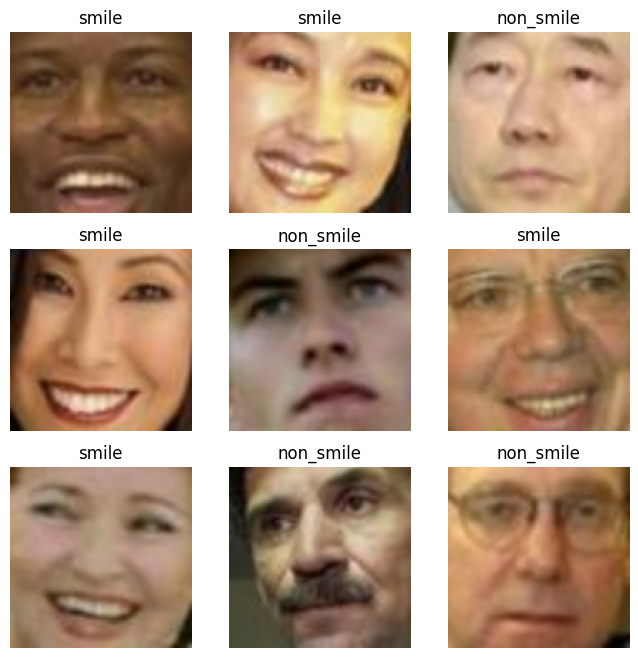

In [ ]:
# Plot few images randomly.
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 8))
class_names = folders
for images, labels in train_ds.take(1):
    print("Image shape: ", images.numpy().shape)
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels.numpy()[i]])
        plt.axis("off")

## Preprocess

In [ ]:
# Scaling the images for better performance.
normalization_layer = tf.keras.layers.Rescaling(1./255)
def pre_process(x, y):
    x = normalization_layer(x)
    return x, y

n_train_ds = train_ds.map(lambda x, y: pre_process(x, y))
n_val_ds = val_ds.map(lambda x, y: pre_process(x, y))

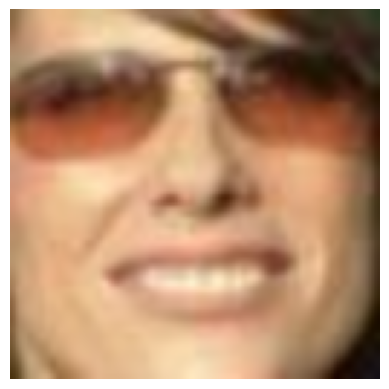

In [ ]:
# Printing the image post normalization
for img, label in n_train_ds.take(1):
  plt.imshow(img[0].numpy())
  plt.axis('off')
  break

## Encoder model.

In the Encoder layer we compress the input data to a vector fo size 4096.
We use a combination of Convolution layers, Batch normalization and dropouts to avoid overfitting.



In [ ]:
input_data = tf.keras.layers.Input(shape=(img_height, img_width, 3))
encoder = tf.keras.layers.Conv2D(32, (3,3), activation='relu', strides=2)(input_data)
encoder = tf.keras.layers.BatchNormalization()(encoder)
encoder = tf.keras.layers.Dropout(0.25)(encoder)

encoder = tf.keras.layers.Conv2D(64, (3,3), activation='relu', strides=2)(encoder)
encoder = tf.keras.layers.BatchNormalization()(encoder)
encoder = tf.keras.layers.Dropout(0.25)(encoder)

encoder = tf.keras.layers.Conv2D(64, (3,3), activation='relu', strides=2)(encoder)
encoder = tf.keras.layers.BatchNormalization()(encoder)
encoder = tf.keras.layers.Dropout(0.25)(encoder)

encoder = tf.keras.layers.Conv2D(64, (3,3), activation='relu', strides=2)(encoder)
encoder = tf.keras.layers.BatchNormalization()(encoder)
encoder = tf.keras.layers.Dropout(0.25)(encoder)

encoder = tf.keras.layers.Flatten()(encoder)
encoder = tf.keras.layers.Dense(4096)(encoder)

## Mean and Variance vector.

The output of the encoder is further reduced to 2 dimension vector of size 200.
The output is then passed through a lambda function that calculates epsilon.
Epsilon is the random normal distribution, the size of the sample must be equal to batch size. Finally we apply the log var trick, as explained in the below equation

![image.png](https://github.com/sriksmachi/sriksml/blob/main/genai/images/log-var-vae.png?raw=1)

𝑍 => represents the final value <br/>
ᵁ => mean </br>
σ => variance <br/>
ϵ => Standard Multivariate normal distribution of mean  = 0, and standard deviation = 1 <br/>

Why log var trick ?
Log of variance allows the values to be both positive and negative.

In summary, the output of this network will force the distribution to be of standard normal distribution. This makes the data points are continuous and images of same class are encoded alike.

In [ ]:

def sample_latent_features(distribution):
    distribution_mean, distribution_variance = distribution
    batch_size = tf.keras.backend.shape(distribution_mean)
    epsilon = tf.keras.backend.random_normal(shape=batch_size, mean=0, stddev=1)
    return distribution_mean + tf.exp(0.5 * distribution_variance) * epsilon

dist_mean = tf.keras.layers.Dense(200, name='mean')(encoder)
dist_variance = tf.keras.layers.Dense(200, name='log_variance')(encoder)
latent_encoding = tf.keras.layers.Lambda(sample_latent_features)([dist_mean, dist_variance])
encoder_model = tf.keras.Model(input_data, latent_encoding)
encoder_model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d_4 (Conv2D)           (None, 63, 63, 32)           896       ['input_4[0][0]']             
                                                                                                  
 batch_normalization_10 (Ba  (None, 63, 63, 32)           128       ['conv2d_4[0][0]']            
 tchNormalization)                                                                                
                                                                                                  
 dropout_10 (Dropout)        (None, 63, 63, 32)           0         ['batch_normalization_10

## Decoder Model

The decoder model does the opposite, it takes the latent vector and performs deconvolution and upsampling to reconstruct the images. We apply the deconvolution layers until we reach the inout shape of the image.


In [ ]:
decoder_input = tf.keras.layers.Input(shape=(200))
decoder = tf.keras.layers.Dense(4096)(decoder_input)
decoder = tf.keras.layers.Reshape((8, 8, 64))(decoder)

decoder = tf.keras.layers.Conv2DTranspose(64, (2,2), activation='relu', strides=2)(decoder)
decoder = tf.keras.layers.BatchNormalization()(decoder)
decoder = tf.keras.layers.Dropout(0.25)(decoder)

decoder = tf.keras.layers.Conv2DTranspose(64, (2,2), activation='relu', strides=2)(decoder)
decoder = tf.keras.layers.BatchNormalization()(decoder)
decoder = tf.keras.layers.Dropout(0.25)(decoder)

decoder = tf.keras.layers.Conv2DTranspose(32, (2,2), activation='relu', strides=2)(decoder)
decoder = tf.keras.layers.BatchNormalization()(decoder)
decoder = tf.keras.layers.Dropout(0.25)(decoder)

decoder_output = tf.keras.layers.Conv2DTranspose(3, (2,2), activation='relu', strides=2)(decoder)
decoder_model = tf.keras.Model(decoder_input, decoder_output)
decoder_model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 200)]             0         
                                                                 
 dense_4 (Dense)             (None, 4096)              823296    
                                                                 
 reshape_2 (Reshape)         (None, 8, 8, 64)          0         
                                                                 
 conv2d_transpose_8 (Conv2D  (None, 16, 16, 64)        16448     
 Transpose)                                                      
                                                                 
 batch_normalization_14 (Ba  (None, 16, 16, 64)        256       
 tchNormalization)                                               
                                                                 
 dropout_14 (Dropout)        (None, 16, 16, 64)        0   

## Loss Function

The loss function here has two objectives. The first term ensures the reconstruction loss is minimum, and the second term ensures that the distribution of latent vector is near to standard normal distribution also called KL-divergence.

![image.png](https://github.com/sriksmachi/sriksml/blob/main/genai/images/vae-total-loss.png?raw=1)

The first term is implemented as MSE, i.e. the mean squared error of predicted data vs. actual data.

![image.png](https://github.com/sriksmachi/sriksml/blob/main/genai/images/vae-loss.png?raw=1)

The second term KL-divergence loss acts as a regularization term and it is implemented using function shown below. KL loss ensures that distribution of the latent vector and the standard normal distribution is minimum.

![image.png](https://github.com/sriksmachi/sriksml/blob/main/genai/images/vae-kl-loss.png?raw=1)

For a SND, when mean = 0, and variance is 1. The L2 loss becomes 0. Thus forcing the learnt distribution to be of standard normal distribution.


Finally the losses are combined

Note: There are few other forms of regularization
- Denoising criterian : In this approach we add noise to the original input images and instead of passing the original image we pass the corrupted version (image + noise) and make the network learn the original image. _(Bengio et al. 2015)_
- Representation Sparsity: In this approach we force the latent variables in the latent vector to be sparse. This contributes to better generalization and makes the model robust to noise.

In [ ]:
optimizer = tf.keras.optimizers.legacy.Adam(lr = 0.0005)

# Reconstruction loss calculates Mean Square error (MSE) between predicted image and orginal image.
# the loss is then normalized per batch.
def get_reconstruction_loss(y_true, y_pred):
    reconstruction_loss = tf.keras.losses.mse(y_true, y_pred)
    reconstruction_loss_batch = tf.reduce_mean(reconstruction_loss)
    return reconstruction_loss_batch * img_width * img_height

# This function implements KL loss as explained in the equation above.
#
def get_kl_loss(distribution_mean, distribution_variance):
    kl_loss = 1 + distribution_variance - tf.square(distribution_mean) - tf.exp(distribution_variance)
    kl_loss_batch = tf.reduce_mean(kl_loss)
    return kl_loss_batch * (-0.5)

# Total loss is then computed as sum of reconstruction loss and KL Loss
def vae_loss(y_true, y_pred, distribution_mean, distribution_variance):
    reconstruction_loss_batch = get_reconstruction_loss(y_true, y_pred)
    kl_loss_batch = get_kl_loss(distribution_mean, distribution_variance)
    return reconstruction_loss_batch + kl_loss_batch

## Training

In [ ]:
# In this method we define the training step, we send the images through the encoder network the produces the latent vector.
# The latent vector is then passed through the decoder network to reconstruct the image.
# During backprop the generated images are used to compute vae loss.
@tf.function
def train_step(images):
    with tf.GradientTape() as enc, tf.GradientTape() as dec:
        latent = encoder_model(images)
        generated_images = decoder_model(latent)
        loss = vae_loss(images, generated_images, latent[0], latent[1])
    gradients_of_enc = enc.gradient(loss, encoder_model.trainable_variables)
    gradients_of_dec = dec.gradient(loss, decoder_model.trainable_variables)
    optimizer.apply_gradients(zip(gradients_of_enc, encoder_model.trainable_variables))
    optimizer.apply_gradients(zip(gradients_of_dec, decoder_model.trainable_variables))
    return loss

In [ ]:
import tqdm

# For better clarity of images run for more epochs - 10k, 20k
# 10 K will take roughly 4 hours on V100 GPU
epochs = 1000

def train(dataset, epochs):
    t_losses = []
    b_losses = []
    iteration = 0
    for epoch in tqdm.tqdm(range(epochs)):
        for image_batch, _ in dataset:
            loss = train_step(image_batch)
            b_losses.append(loss)
            iteration += 1
        if epoch % 100 == 0:
          print(f'Epoch: {epoch} | Batch Loss: {loss} | Iteration: {++iteration} | Running loss {np.average(b_losses[-100:])}')
        t_losses.append(np.average(b_losses[:100]))
    return t_losses, b_losses
t_losses, b_losses = train(n_train_ds, epochs)


  0%|          | 1/1000 [00:02<46:21,  2.78s/it]

Epoch: 0 | Batch Loss: 1105.2459716796875 | Iteration: 31 | Running loss 2299949.5


 10%|█         | 101/1000 [00:52<07:25,  2.02it/s]

Epoch: 100 | Batch Loss: 73.53402709960938 | Iteration: 3131 | Running loss 59.92731857299805


 20%|██        | 201/1000 [01:42<06:36,  2.01it/s]

Epoch: 200 | Batch Loss: 20.918928146362305 | Iteration: 6231 | Running loss 24.30019760131836


 30%|███       | 301/1000 [02:31<05:45,  2.02it/s]

Epoch: 300 | Batch Loss: 16.206148147583008 | Iteration: 9331 | Running loss 18.9206600189209


 40%|████      | 401/1000 [03:21<04:57,  2.01it/s]

Epoch: 400 | Batch Loss: 15.368167877197266 | Iteration: 12431 | Running loss 13.351783752441406


 50%|█████     | 501/1000 [04:10<04:08,  2.01it/s]

Epoch: 500 | Batch Loss: 12.00589656829834 | Iteration: 15531 | Running loss 11.940451622009277


 60%|██████    | 601/1000 [05:00<03:19,  2.00it/s]

Epoch: 600 | Batch Loss: 10.597794532775879 | Iteration: 18631 | Running loss 12.764229774475098


 70%|███████   | 701/1000 [05:50<02:29,  2.00it/s]

Epoch: 700 | Batch Loss: 12.38195514678955 | Iteration: 21731 | Running loss 14.793269157409668


 80%|████████  | 801/1000 [06:40<01:39,  2.01it/s]

Epoch: 800 | Batch Loss: 8.732632637023926 | Iteration: 24831 | Running loss 8.051366806030273


 90%|█████████ | 901/1000 [07:30<00:49,  1.99it/s]

Epoch: 900 | Batch Loss: 7.366351127624512 | Iteration: 27931 | Running loss 7.931653022766113


100%|██████████| 1000/1000 [08:20<00:00,  2.00it/s]


## Plot Loss

In this section we plot the training loss as a function of total iterations & Epochs. You should notice convergence curve (as shown below) if the model has learnt to reconstruct the images.

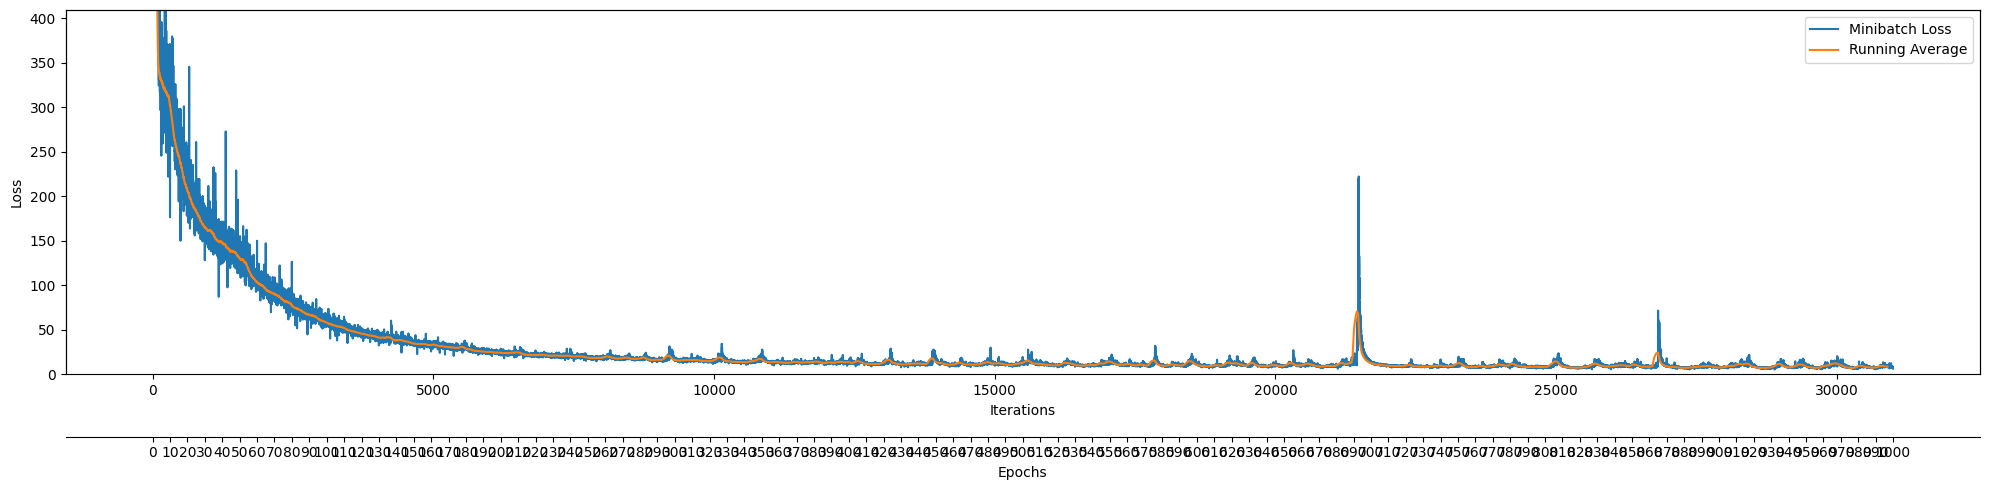

In [ ]:
def plot_train_loss(b_losses, t_losses, num_epochs, averaging_iterations=100, custom_label = ''):
    plt.figure(figsize=(20,5))
    iter_per_epoch = len(b_losses) // num_epochs
    ax1 = plt.subplot(1, 1, 1)
    ax1.plot(range(len(b_losses)),(b_losses), label=f'Minibatch Loss{custom_label}')
    ax1.set_xlabel('Iterations')
    ax1.set_ylabel('Loss')
    if len(b_losses) < 1000:
        num_losses = len(b_losses) // 2
    else:
        num_losses = 1000
    ax1.set_ylim([0, np.max(b_losses[num_losses:])*1.5])
    ax1.plot(np.convolve(b_losses, np.ones(averaging_iterations,)/averaging_iterations, mode='valid'), label=f'Running Average{custom_label}'),
    ax1.legend()
    ##################
    # Set scond x-axis
    ax2 = ax1.twiny()
    newlabel = list(range(num_epochs+1))
    newpos = [e*iter_per_epoch for e in newlabel]
    ax2.set_xticks(newpos[::10])
    ax2.set_xticklabels(newlabel[::10])
    ax2.xaxis.set_ticks_position('bottom')
    ax2.xaxis.set_label_position('bottom')
    ax2.spines['bottom'].set_position(('outward', 45))
    ax2.set_xlabel('Epochs')
    ax2.set_xlim(ax1.get_xlim())
    ###################
    plt.tight_layout()

plot_train_loss(b_losses, t_losses, epochs)

## Generating images from latent vector using input images

In this section we are using the trained network to reconstruct the images from the same input images.

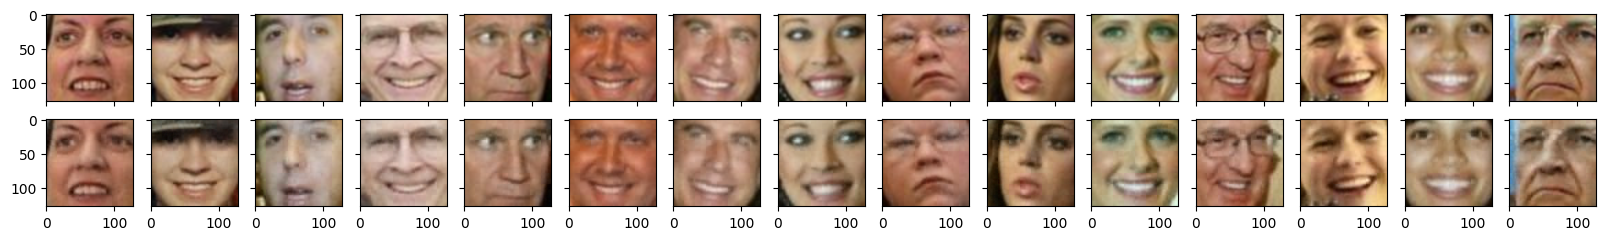

In [ ]:
def plot_generated_images(data_loader, model, unnormalizer=None, figsize=(20, 2.5), n_images=15, modeltype='autoencoder'):
    fig, axes = plt.subplots(nrows=2, ncols=n_images, sharex=True, sharey=True, figsize=figsize)
    orig_images = []
    pred_images = []
    color_channels = 3
    image_height = img_height
    image_width = img_width
    for img_batch, label in data_loader.take(1):
        for img in img_batch:
          latent = encoder_model(img.numpy().reshape(1, image_height, img_width, color_channels))
          predictions = decoder_model(latent)[0]
          pred_images.append(predictions)
          orig_images.append(img)
    for i in range(n_images):
        for ax, img in zip(axes, [orig_images, pred_images]):
            curr_img = img[i]
            ax[i].imshow(curr_img)

plot_generated_images(n_train_ds, decoder_model)

The images are blurred due to the low dimensionality of the latent vector. Variational Autoencoders(VAEs) are not designed to reconstruct the images, the primary purpose is only to learn the underlying distribution.

## Generating images from latent vector using random noise

We can also generate images from random noise as shown below.
The images will have more clarity if we train for longer period.
However, we cannot generate images as good as the input using latent vector.
To produce highly realistic images, GANs are more suitable.

1/1 [==============================] - 0s 23ms/step


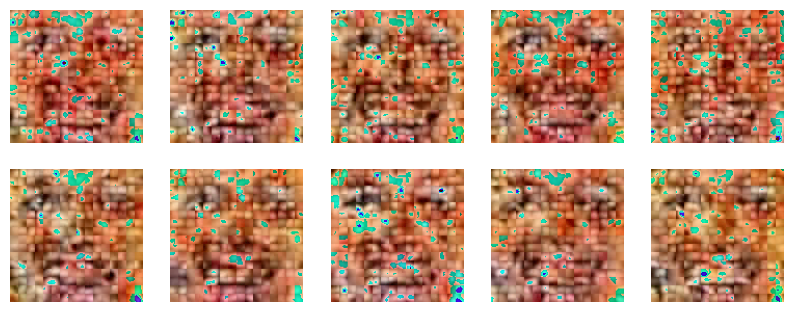

In [ ]:
def plot_generated_images_vae(model, n_images=10, figsize = (10, 10)):
    generator_model = model
    fig = plt.figure(figsize=figsize)
    for i in range(n_images):
        ax = fig.add_subplot(5, 5, i+1)
        x = np.random.random(size = (10,200))
        reconstruct = generator_model.predict(x)[0]
        ax.axis('off')
        pred = reconstruct * 255
        pred = np.array(pred)
        pred = pred.astype(np.uint8)
        ax.imshow(pred)

plot_generated_images_vae(decoder_model)


You may notice that most of the images resemble human face.

## Adding smile to a face

In this section, we will apply basic arithmetic on latent vectors to make a non-smiling face smile. The intuition behind this, is if the latent vector learnt by encoder model of all smiling faces represents an average smiling face, and vice-versa for the non-smiling faces.

In [ ]:
dim = 200
avg_image_with_smile = np.zeros(dim, dtype='float32')
avg_image_without_smile = np.zeros(dim, dtype='float32')
n_images_with_smile = 0
n_images_without_smile = 0
for image_batch, labels in n_train_ds:
  label_idx = [i for i, val in enumerate(labels.numpy()) if val == 1]
  embeddings = encoder_model.predict(image_batch) # output shape (batchsize, latent_vector_dim)
  smile_embeddings = [embeddings[i] for i in label_idx]
  no_smile_embeddings = [embeddings[i] for i in range(len(labels.numpy())) if i not in label_idx]
  avg_image_with_smile += tf.math.reduce_sum(smile_embeddings, axis=0)
  avg_image_without_smile += tf.math.reduce_sum(no_smile_embeddings, axis=0)
  n_images_with_smile += len(smile_embeddings)
  n_images_without_smile += len(no_smile_embeddings)
avg_image_with_smile /= n_images_with_smile
avg_image_without_smile /= n_images_without_smile

1/1 [==============================] - 0s 20ms/step


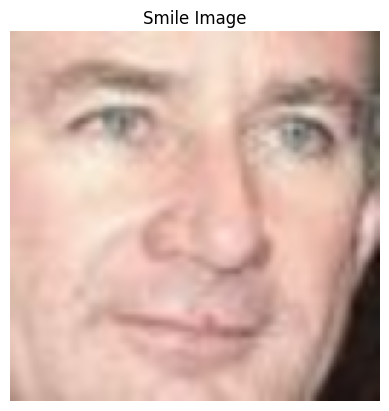

In [ ]:
EXAMPLE_IMAGE = np.zeros(dim, dtype='float32')
for images, labels in n_train_ds:
  label_idx = [i for i, val in enumerate(labels.numpy()) if val == 0]
  EXAMPLE_IMAGE = images[label_idx[0]]
  plt.title('No Smile Image')
  plt.axis('off')
  plt.imshow(EXAMPLE_IMAGE)
  break


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


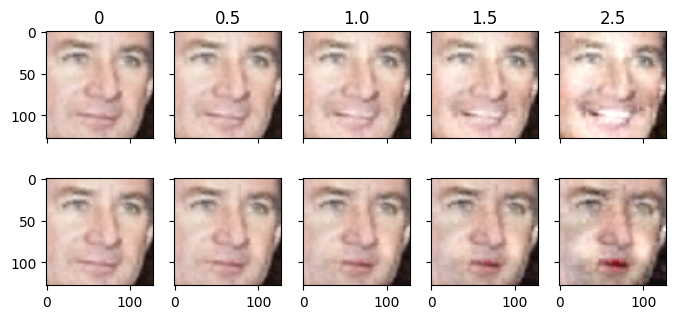

In [ ]:
diff_coefficients = [0, 0.5,1., 1.5, 2.5]
fig, axes = plt.subplots(nrows=2, ncols=len(diff_coefficients), sharex=True, sharey=True, figsize=(8,3.5))
diff = (avg_image_with_smile - avg_image_without_smile)
latent = encoder_model.predict(EXAMPLE_IMAGE.numpy().reshape(1, img_height, img_width, 3))
for i, alpha in enumerate(diff_coefficients):
  more_smile = latent + alpha * diff
  less_smile = latent - alpha * diff
  more = decoder_model.predict(more_smile)[0]
  less = decoder_model.predict(less_smile)[0]
  axes[0,i].set_title(alpha)
  axes[0,i].imshow(more)
  axes[1,i].imshow(less)


## Summary

In summary VAEs are enhanced version of autoencoders with regularization that avoids overfitting and ensures the latent space contains desired properties for effective image generation.

In this notebook we have learnt to develop VAEs that can compress input data source to latent vector with continuous, standard normal distribution. The models can then be used to regenerate the images and also perform minor modifications to the features within the image.

VAEs though powerful, they have certain challenges. Few of them mentioned below.
- The images generated through VAE are blurry and lack clarity compared to original images.
- Trade off between latent loss and reconstruction loss. VAE loss is a combination of latent loss and reconstruction loss. If Latent loss is small, the compressed vector has more information thus the generated images may look a lot like training images. If the reconstruction loss is small, the images during train time look good, but novel generated images will look bad.

Outside image generation VAEs can also be used with different types of data for anomaly detection, data compression.